date
2019-01-31    1547.807692
2019-02-28    1325.458333
2019-03-31    1230.423077
2019-04-30    1088.280000
2019-05-31    1072.384615
2019-06-30     963.880000
2019-07-31    1096.333333
2019-08-31    1100.592593
2019-09-30    1142.240000
2019-10-31    1069.592593
2019-11-30    1179.653846
2019-12-31    1195.333333
2020-01-31    1314.307692
2020-02-29    1086.440000
2020-03-31    1106.480000
2020-04-30    1421.047619
2020-05-31    1275.916667
2020-06-30    1257.960000
2020-07-31    1209.074074
Name: volume, dtype: float64


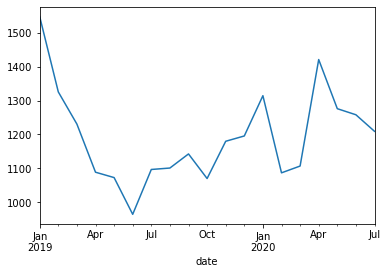

In [9]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
series = read_csv('TP_month.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# summarize first few rows
print(series.head(20))
# line plot
series.plot()
pyplot.show()

In [5]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# load dataset
series = read_csv('TP_month.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# configure
n_lag = 1
n_seq = 3
n_test = 8
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[1142.24     1069.592593 1179.653846 1195.333333]
 [1069.592593 1179.653846 1195.333333 1314.307692]
 [1179.653846 1195.333333 1314.307692 1086.44    ]
 [1195.333333 1314.307692 1086.44     1106.48    ]
 [1314.307692 1086.44     1106.48     1421.047619]
 [1086.44     1106.48     1421.047619 1275.916667]
 [1106.48     1421.047619 1275.916667 1257.96    ]
 [1421.047619 1275.916667 1257.96     1209.074074]]
Train: (8, 4), Test: (8, 4)


### Persistent Forecasts

t+1 RMSE: 159.739216
t+2 RMSE: 179.464798
t+3 RMSE: 155.909393


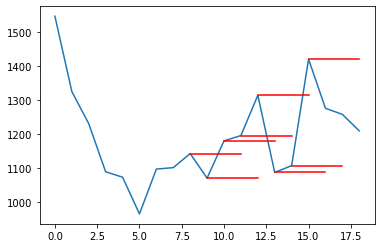

In [6]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = read_csv('TP_month.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# configure
n_lag = 1
n_seq = 3
n_test = 8
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

### Multi-Step LSTM Network
Use the persistence example as a starting point and look at the changes needed to fit an LSTM to the training data and make multi-step forecasts for the test dataset.

t+1 RMSE: 159.739216
t+2 RMSE: 179.464798
t+3 RMSE: 155.909393


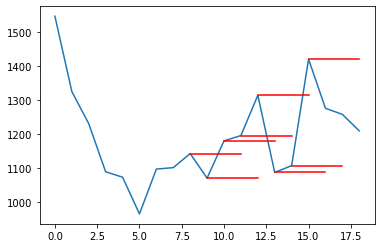

In [10]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# date-time parsing function for loading the dataset

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = read_csv('TP_month.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# configure
n_lag = 1
n_seq = 3
n_test = 8
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)